In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        
        # Allow any action to be taken with at least epsilon/nA probability
        A = np.array([epsilon/nA] * nA)
        
        # Create action-value if not exist in Q
        if observation not in Q:
            Q[observation] = np.zeros(env.action_space.n)
        
        # Allow greedy action to be taken with 1 - epsilon + epsilon/nA probability
        A[np.argmax(Q[observation])] += (1 - epsilon)
        
        return A
        
        
    return policy_fn

In [4]:
def mc_control_epsilon_greedy(env, num_episodes, gamma=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = {}
    returns_count = {}
    
    # The final action-value function
    Q = {}
    
    # Use epsilon-greedy policy
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for episode in range(num_episodes):
        
        # env.reset() resets the env by dealing new cards and returns the
        # starting state (sum of hand, one dealer card, usable ace) as a tupe.
        St = env.reset()
        seq_sa, seq_rewards, terminate = [], [], False
        
        # Iterate through episode until termination
        while not terminate:
        
            p = policy(St)
            At = np.random.choice(np.arange(len(p)), p=p)
            
            # env.step() takes action At and returns the new state
            # as a tuple, the reward for taking action At and a flag
            # that is True if we end up in the terminal state. For some
            # reason, step() also returns an empty dict that we ignore.
            St_new, Rt, terminate, _ = env.step(At)
            
            # Append state and given reward to sequence and
            # move to the new state after taking action At.
            seq_sa.append((St, At))
            seq_rewards.append(Rt)
            St = St_new
            
        # Now that we have terminated we update the average return
        # of all states that we visited during this particular episode.
        for idx, sa in enumerate(set(seq_sa)):
            
            # Get index of first visit
            fv = seq_sa.index(sa)
            
            # Create key in dict if not exist
            if sa not in returns_sum:
                returns_sum[sa] = 0
                returns_count[sa] = 0
            
            # Compute sampled return from state
            G = 0
            for t, Rt in enumerate(seq_rewards[fv:]):
                G += (gamma ** t) * Rt
            
            # Update action-value function estimation for pair
            returns_sum[sa] += G
            returns_count[sa] += 1
            Q[sa[0]][sa[1]] = returns_sum[sa] / returns_count[sa]

    return Q, policy

In [8]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=5000000, epsilon=0.1)

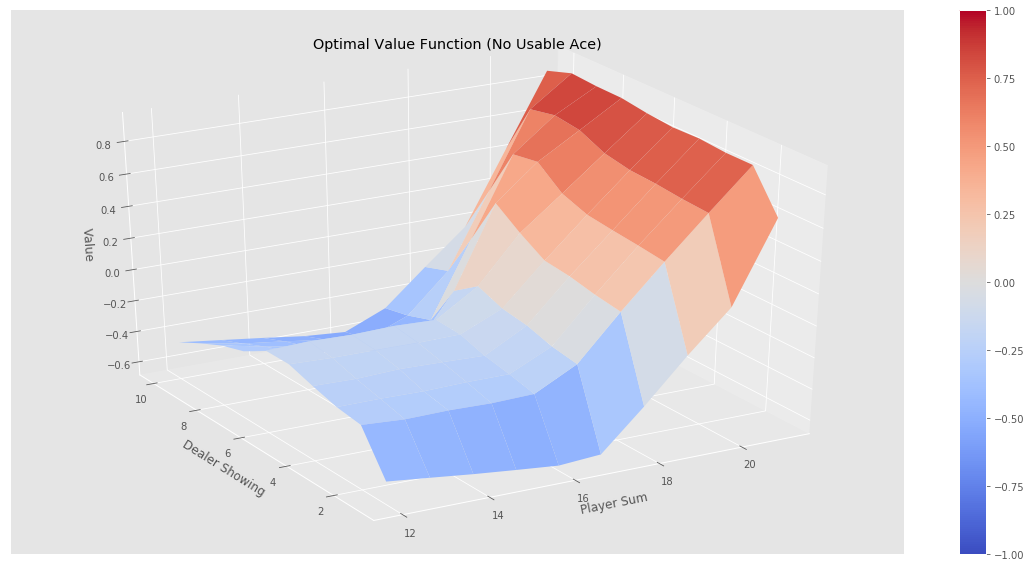

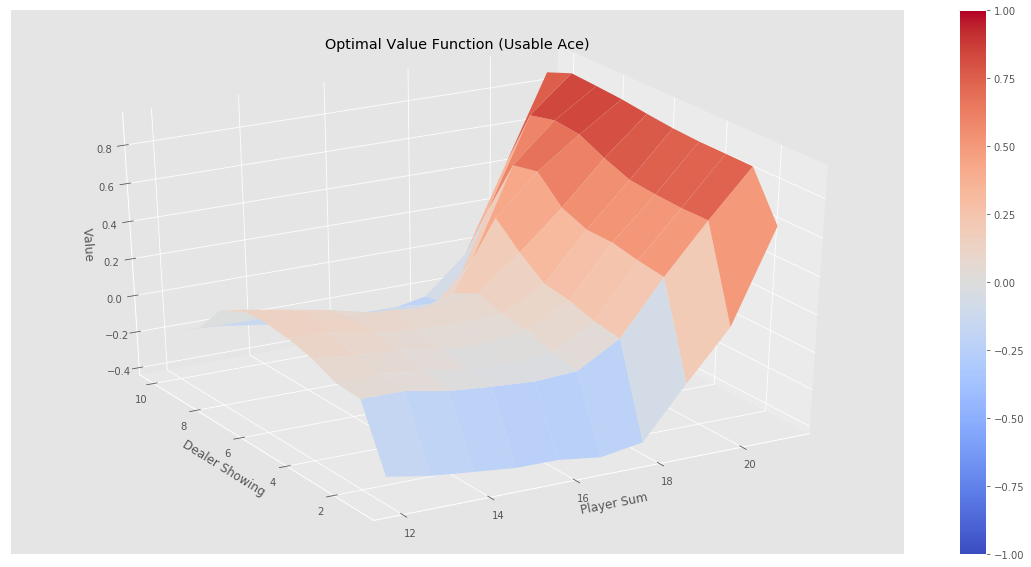

In [9]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")